Import Libraries and Packages

In [1]:
import sys
sys.path.append(".")
import unittest
import numpy as np
import matplotlib.pyplot as plt

from src.susie.timing_data import TimingData
from src.susie.ephemeris import Ephemeris
from scipy.optimize import curve_fit
from astropy import time
from astropy import coordinates as coord
from astropy import units as u

ModuleNotFoundError: No module named 'astroquery'

Importing the Data

In [ ]:
test_epochs_precession = np.array([ -1640, -1346,  -1342, -1067, -1061, -1046,  -1038])
test_mtts_precession = np.array([2454515.525,2454836.403,2454840.769,2455140.91, 2455147.459, 2455163.831,2455172.561])
test_mtts_err_precession = np.array([0.00043, 0.00028, 0.00062, 0.00042, 0.00043, 0.00032, 0.00036])
test_tra_or_occ_precession = np.array(['tra','occ','occ','tra', 'tra', 'tra', 'tra'])

Creating the TimingData and Ephemeris objects

In [ ]:
# Create new transit times object with above data
timing_obj1 = TimingData('jd', test_epochs_precession, test_mtts_err_precession, mid_time_uncertainties=test_mtts_err_precession, tra_or_occ=test_tra_or_occ_precession, time_scale='tdb')
ephemeris_obj1 = Ephemeris(timing_obj1)

Linear Model

In [ ]:
# Getting a linear model will solve for period and conjuction time (and their respective errors)
linear_model_data = ephemeris_obj1.get_model_ephemeris('linear')

for key, value in linear_model_data.items():
    print(f"{key}: {value}\n")

period: -3.668678964975163e-08

period_err: 1.844452095001672e-07

conjunction_time: 0.00038323870163063943

conjunction_time_err: 8.81049593290902e-05

model_type: linear

model_data: [0.00038324 0.00037243 0.00037229 0.00036222 0.000362   0.00036145
 0.00036115]



Quadratic Model

In [ ]:
# Getting a linear model will solve for period and conjuction time (and their respective errors)
quadratic_model_data = ephemeris_obj1.get_model_ephemeris('quadratic')

for key, value in quadratic_model_data.items():
    print(f"{key}: {value}\n")

period: -4.634905019914829e-07

period_err: 7.828665116255608e-07

conjunction_time: 0.00042539394983421474

conjunction_time_err: 0.00012076361402648409

period_change_by_epoch: 1.2509678649564702e-09

period_change_by_epoch_err: 2.21961880883636e-09

model_type: quadratic

model_data: [0.00042539 0.00034296 0.00034259 0.00036518 0.00036672 0.00037077
 0.00037305]



Precession Model

In [ ]:
# Getting a linear model will solve for period and conjuction time (and their respective errors)
precession_model_data = ephemeris_obj1.get_model_ephemeris('precession')

for key, value in precession_model_data.items():
    print(f"{key}: {value}\n")

period: -4.1790876785831535e-08

period_err: 5.314079594892487e-07

conjunction_time: 0.0003855570895877751

conjunction_time_err: 0.00021852965890797033

eccentricity: 0.9789375209244587

eccentricity_err: 623.0296729710553

pericenter: -8018.2712353507195

pericenter_err: 2349.3225316490507

pericenter_change_by_epoch: 5.687365414147889

pericenter_change_by_epoch_err: 5.678868219567694

model_type: precession

model_data: [0 0 0 0 0 0 0]



In [ ]:
def anomalistic_period(P, dwdE):
    """Calculates the anomalistic period given a period and a change in pericenter with respect to epoch.

    Uses the equation:
    P / (1 - (1/(2*pi)) * dwdE)

    Parameters
    ----------
    P: float
        The exoplanet sideral orbital period.
    dwdE: float
        Change in pericenter with respect to epoch.

    Returns
    -------
        A float of the calculated starting anomalistic period.
    """
    result = P/(1 - (1/(2*np.pi))*dwdE)
    return result
    
def pericenter(w0, dwdE, E):
    """Calculates the pericenter given a list of epochs, an intial pericenter value, and a change in pericenter with respect to epoch.

    Uses the equation:
    w0 + dwdE * E

    Parameters
    ----------
    E: numpy.ndarray[int]
        The epochs.
    dwdE: float
        Change in pericenter with respect to epoch.
    w0: int
        The intial pericenter.

    Returns
    -------
        A numpy.ndarray[float] of the calculated pericenter as a function of epochs.
    """
    result = w0 + dwdE*E
    return result

def precession_fit(E, T0, P, dwdE, w0, e, tra_or_occ):
    """Calculates a precession function with given data.

    Uses the equation 
        -  conjunction time + (epochs * period) - ((eccentricity * anomalistic period) / pi) * cos(pericenter) for transit observations
        -  conjunction time + (anomalistic period / 2) + epochs * period + ((eccentricity * anomalistic period) / pi) * cos(pericenter) for occultation observations as a precession function for the LMfit Model.
    
    Parameters
    ----------
        e: float
            The eccentricity.
        E: numpy.ndarray[int]
            The epochs.
        dwdE: float
            Change in pericenter with respect to epoch.
        P: float
            The exoplanet sideral orbital period.
        T0: float
            The initial mid-time, also known as conjunction time.
        tra_or_occ: numpy.ndarray[str]
            Indicates if the data is from a transit or occultation.
        w0: int
            The intial pericenter.
    
    Returns
    -------
        result: numpy.ndarray[float]
            A precession function to be used with the LMfit Model, returned as:
            :math:`T0 + E*P - \\frac{e * \\text{self.anomalistic_period}(P,dwdE)}{\\pi} * \\cos(\\text{self.pericenter}(w0, dwdE, E))`
            :math:`T0 + \\frac{\\text{self.anomalistic_period}(P,dwdE)}{2} + E*P + \\frac{e * \\text{self.anomalistic_period}(P,dwdE)}{\\pi} * \\cos(\\text{self.pericenter}(w0, dwdE, E))`
    """
    # anomalistic_period = anomalistic_period(P, dwdE)
    # pericenter = pericenter(w0, dwdE, E)
    result = np.zeros(len(E))
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 0:
            # transit data
            result[i] = T0 + E[i]*P - ((e*anomalistic_period(P, dwdE))/np.pi)*np.cos(pericenter(w0, dwdE, E[i]))
        elif t_type == 1:
            # occultation data
            result[i] = T0 + anomalistic_period(P, dwdE)/2 + E[i]*P + ((e*anomalistic_period(P, dwdE))/np.pi)*np.cos(pericenter(w0, dwdE, E[i]))
    return result

In [ ]:
tra_or_occ_enum = np.zeros(len(test_epochs_precession))
prec_transit_times = precession_fit(test_epochs_precession, 0.0003855570895877751,  -4.1790876785831535e-08,  5.687365414147889 ,-8018.2712353507195 ,  0.9789375209244587, tra_or_occ=test_tra_or_occ_precession)

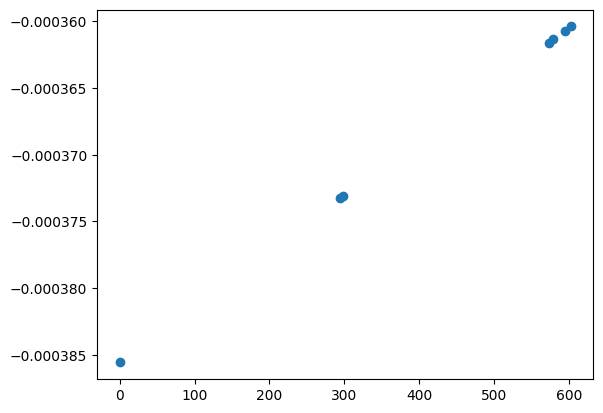

In [ ]:
plt.scatter(test_epochs_precession, (prec_transit_times -  0.0003855570895877751 -  -4.1790876785831535e-08* test_epochs_precession))